In [1]:
import cv2
import mmcv
import os
import sys
import numpy as np
import math
from multiprocessing import Pool
!pwd
sys.path.insert(0, '../../')
sys.path.insert(0, '../../mmdetection/')
# os.chdir('/home/wff/weakly-supervised/')
from curve.ops.polylabel import polylabel
from shapely.geometry import Polygon, LinearRing, LineString, MultiLineString, GeometryCollection
import matplotlib.pyplot as plt
%matplotlib inline
anno_path = '../../data/TotalText/Annotations/'
img_path = '../../data/TotalText/JPGImages/'
gap_path = '../..../../data/TotalText/Masks_gap/'
mask_path = '../../data/TotalText/Masks_dilate/'
anno_list = os.listdir(anno_path)
img_list = os.listdir(img_path)
len(img_list)

/home/lingchen.zlm/project/textseg/curve/notebooks


1555

In [2]:
def load_ann_total(filename):
    with open(filename) as f:
        texts = f.read().split('x: [[')[1:]
    num_objs = len(texts)
    polygon_list = []
    for i in range(num_objs):
        try:
            text = texts[i].split(',')
            x = text[0][:-2].split()
            x = np.array(x, dtype = np.float32)
            y = text[1][6:-2].split()
            y = np.array(y, dtype = np.float32)
            box = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
            hard = (text[-1][20:-3] == '#')
            polygon = Polygon(box)
        except Exception as err:
            print(filename, texts[i], err)
        if hard==0:
            polygon_list.append([polygon, hard])
    return polygon_list

def load_ann_ctw(filename):
    with open(filename) as f:
        texts = f.readlines()
    num_objs = len(texts)
    polygon_list = []
    for i in range(num_objs):
        try:
            box = texts[i].split(',')
            box = np.array(box, dtype=np.float32)
            box[4::2] += box[0]
            box[5::2] += box[1]
            box = box[4:]
            hard = 0
            polygon = Polygon(box.reshape((-1, 2)))
        except Exception as err:
            print(filename, texts[i], err)
        polygon_list.append([polygon, hard])
    return polygon_list

In [6]:
def dilate_instance(anno):
    idx = anno[:4]
    polygons = load_ann_total(anno_path + anno)
    im = cv2.imread(img_path + idx +'.jpg')
    mask_gt = np.zeros((im.shape[0], im.shape[1]), np.uint8)
#     mask_gap = np.zeros((im.shape[0], im.shape[1]), np.uint8)
    gt_name = os.path.join(mask_path + idx +'.png')
#     gap_name = os.path.join(gap_path + idx +'.png')

    for i in range(len(polygons)):
        polygon = polygons[i][0]
        x, y = polygon.exterior.xy
        contours = np.array([x, y]).T.astype(np.int32) # Nx2
        r = polylabel(polygon).distance(polygon.exterior)
        r = int(min(r*0.4, im.shape[0]/50))
        dilated = polygon.buffer(r)
        x2, y2 = dilated.exterior.xy
        contours2 = np.array([x2, y2]).T.astype(np.int32) # Nx2
        m2 = np.zeros((im.shape[0], im.shape[1]), np.uint8)
        cv2.fillPoly(m2, [contours2], 1)
        mask_gt += m2
    # save
    mask_gt[mask_gt>0]=255
    cv2.imwrite(gt_name, mask_gt)
#     mask_gap[mask_gap<=1]=0
#     mask_gap[mask_gap>0]=255
#     cv2.imwrite(gap_name, mask_gap)
#     print('.', end='', flush=True)
#     if h%100==0:
#         print(h, idx)

In [ ]:
pool = Pool(24)
pool.map(dilate_instance, anno_list)


0003


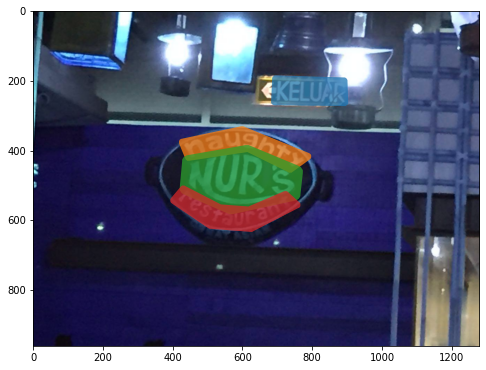

In [15]:
anno = anno_list[15]
idx = anno[:4]
print(idx)
polygons = load_ann_total(anno_path + anno)
im = cv2.imread(img_path + idx +'.jpg')
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im)

for i in range(len(polygons)):
    polygon = polygons[i][0]
    x, y = polygon.exterior.xy
#     r = polygons[i][0].centroid.distance(polygons[i][0].exterior)
#     print(i, r, polygons[i])
    r = polylabel(polygon).distance(polygon.exterior)
    r = int(min(r*0.4, im.shape[0]/50))
#     contours = np.array(list(polygons[i][0].exterior.coords))
    contours = np.array([x, y]).T.astype(np.int32)
    dilated = polygon.buffer(r)
    x2, y2 = dilated.exterior.xy
    contours2 = np.array([x2, y2]).T.astype(np.int32)
    x = contours2[:, 0]
    y = contours2[:, 1]
    ax.fill(x, y, alpha=0.75)
plt.show()

5.680650356296522
0.2410147997252206
5.112822948281195
3.334651298090281
4.8791086834453985
5.337678273522727
9.851480729873721
5.426527175498059
5.540520965776062
4.872030627901676


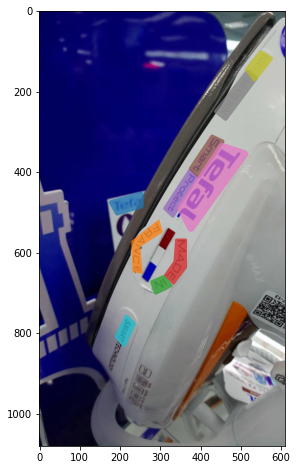

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im)

for i in range(len(polygons)):
    polygon = polygons[i][0]
    r = polygon.centroid.distance(polygon.exterior)
    print(r*0.4)
    dilated = polygon.buffer(r*0.4)
    x, y = dilated.exterior.xy
    ax.fill(x, y, alpha=0.75)
plt.show()

In [ ]:
import cv2
import numpy as np
gt_mask = np.zeros((im.shape[0], im.shape[1]), np.uint8)

for i in range(len(polygons)):
    polygon = polygons[i][0]
    r = polygon.centroid.distance(polygon.exterior)
    dilated = polygon.buffer(r*0.4)
    x, y = dilated.exterior.xy
    contours = np.array([x, y]).T.astype(np.int32) # Nx2
    mask = np.zeros((im.shape[0], im.shape[1]), np.uint8)
    cv2.fillPoly(mask, [contours], 1)
    gt_mask += mask
# gt_mask[gt_mask<=1]=0
# gt_mask[gt_mask>0]=1
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(gt_mask)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(im)

import cv2
import numpy as np
gt_mask = np.zeros((im.shape[0], im.shape[1]), np.uint8)

image_size = (im.shape[0]+im.shape[1])/2
border_size = int(image_size / 64.0)
print("image_size, border_size:", image_size, border_size)
for i in range(len(polygons)):
    polygon = polygons[i][0]
#     bbox = polygon.minimum_rotated_rectangle.exterior.coords.xy
#     r = polygon.centroid.distance(polygon.exterior)
#     dilated = polygon.buffer(r*0.5)
    x, y = polygon.exterior.xy
    contours = np.array([x, y]).T.astype(np.int32) # Nx2
    mask = np.zeros((im.shape[0], im.shape[1]), np.uint8)
    #cv2.fillPoly(mask, [contours], 1)
    cv2.drawContours(mask, [contours], -1, 1, thickness=border_size)
    gt_mask += mask
print(np.min(gt_mask))
# gt_mask[gt_mask<=1]=0
# gt_mask[gt_mask>0]=1
ax.imshow(gt_mask)
plt.show()


(718, 583)
[0 2 3]


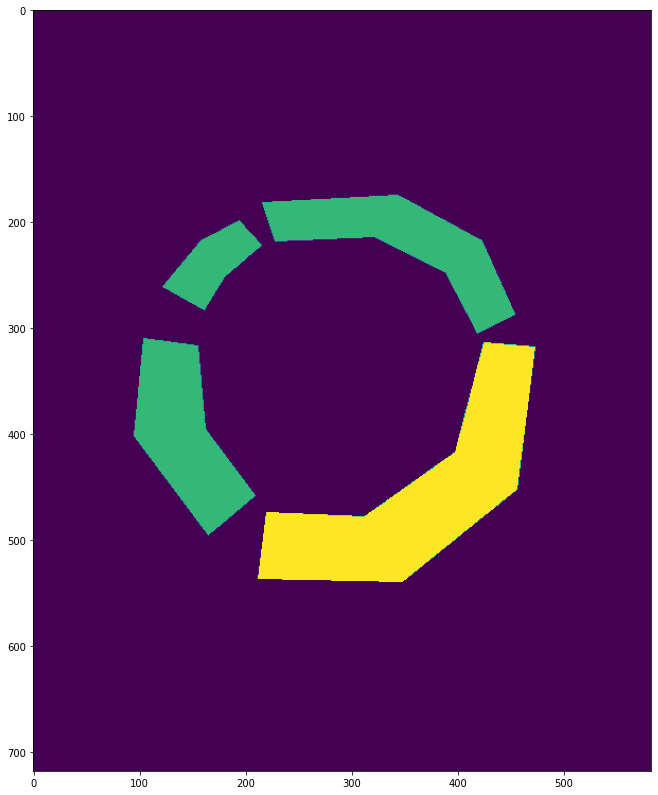

In [68]:
import cv2
png_file = cv2.imread('/home/wff/weakly-supervised/data/TotalText/Masks_sml/0339.png',cv2.IMREAD_GRAYSCALE)
print(png_file.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.imshow(png_file)
print(np.unique(png_file))